# [Домашнє завдання до модуля «Практичні приклади використання згорткових мереж»](https://www.edu.goit.global/learn/25315460/26519706/26524685/homework)

## Dataset: [Indoor Objects Detection](https://www.kaggle.com/datasets/thepbordin/indoor-object-detection)

### Imports & Config

In [1]:
import os, random, warnings, shutil
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
from tempfile import TemporaryDirectory
from PIL import Image
from tqdm.auto import tqdm
import yaml
import random

import torch
from torch.utils.data import WeightedRandomSampler
from ultralytics import YOLO


warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

tmp_dir_ctx = TemporaryDirectory()
MODEL_DIR = Path(tmp_dir_ctx.name) / "ckpt"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Checkpoints are saved in: {MODEL_DIR}")

%matplotlib inline
! wandb disabled

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoints are saved in: /tmp/tmpvs6begvx/ckpt
/bin/bash: line 1: wandb: command not found


In [2]:
class CFG:
    run_name = "yolo_indoor_objects"
    debug = False  # Set to True to make quick experiments
    fraction = 0.05 if debug else 1.0
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 32
    autoanchor = True
    augment = {
        "copy_paste": 0.15,
        "copy_paste_mode": "flip",
        "augment": True,
        "mosaic": True,
        "close_mosaic": 10,
        "mixup": 0.5,
        "hsv_h": 0.015,
        "hsv_s": 0.7,
        "hsv_v": 0.4,
        "degrees": 2.0,
        "translate": 0.1,
        "scale": 0.5,
    }
    classes = [
        "door",
        "cabinetDoor",
        "refrigeratorDoor",
        "window",
        "chair",
        "table",
        "cabinet",
        "couch",
        "openedDoor",
        "pole",
    ]
    num_classes_to_train = len(classes)

    # training
    epochs = 3 if debug else 150
    warmup_epochs = 5
    batch_size = 8

    base_model = (
        "yolov9e"  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    )
    base_model_weights = f"{base_model}.pt"
    exp_name = f"ppe_css_{epochs}_epochs"

    optimizer = "auto"  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    autoanchor = True
    lr = 3e-4
    lr_factor = 0.01
    weight_decay = 5e-4
    dropout = 0.1
    patience = 40
    profile = False
    scheduler = "CosineAnnealingLR"
    label_smoothing = 0.1
    imgsz = 768
    custom_dataset_dir = os.path.expanduser("~/Projects/DataSets/GoIT/Indoor_Objects_Detection/")
    output_dir = Path.cwd().parent

print(f"Using device: {CFG.device}")
print(f"Output dir: {CFG.output_dir}")
print(f"Custom dataset dir: {CFG.custom_dataset_dir}")

Using device: cuda
Output dir: /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP
Custom dataset dir: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/


In [3]:
dict_file = {
    "train": os.path.join(CFG.custom_dataset_dir, "train"),
    "val": os.path.join(CFG.custom_dataset_dir, "valid"),
    "test": os.path.join(CFG.custom_dataset_dir, "test"),
    "nc": CFG.num_classes_to_train,
    "names": CFG.classes,
}

with open(os.path.join(CFG.output_dir, "data.yaml"), "w+") as file:
    yaml.dump(dict_file, file)

In [4]:
def read_yaml_file(file_path=CFG.custom_dataset_dir):
    with open(file_path, "r") as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)


file_path = os.path.join(CFG.output_dir, "data.yaml")
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/test
train: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train
val: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid



### Data \& Transforms

In [5]:
def filter_small_boxes(targets, min_area=0.02):
    keep = []
    for t in targets:
        x1, y1, x2, y2, cls = t
        area = (x2 - x1) * (y2 - y1)
        if area >= min_area:
            keep.append(t)
    return torch.stack(keep) if keep else torch.zeros((0, 5))

In [6]:
def display_image(image, print_info=True, hide_axis=False):
    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print("Type: ", type(img), "\n")
        print("Shape: ", np.array(img).shape, "\n")

    if hide_axis:
        plt.axis("off")

    plt.show()

Example image path: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/images/0f6337a1ea2b6cc2.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (706, 1024, 3) 



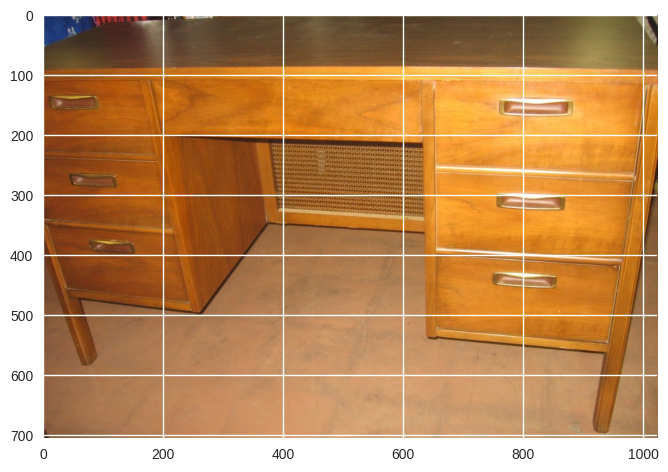

In [7]:

train_img_dir = os.path.join(CFG.custom_dataset_dir, 'train/images')
images = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not images:
    raise FileNotFoundError(f'No images found in {train_img_dir}')
example_image_path = os.path.join(train_img_dir, random.choice(images))
print(f'Example image path: {example_image_path}')
display_image(example_image_path, print_info=True, hide_axis=False)

In [8]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):

    random.seed(seed)

    image_files = [
        f
        for f in os.listdir(folder_path)
        if f.endswith((".jpg", ".png", ".jpeg", ".gif"))
    ]

    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    selected_files = random.sample(image_files, num_images)

    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis("off")
        # ax.set_title(file_name)

    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

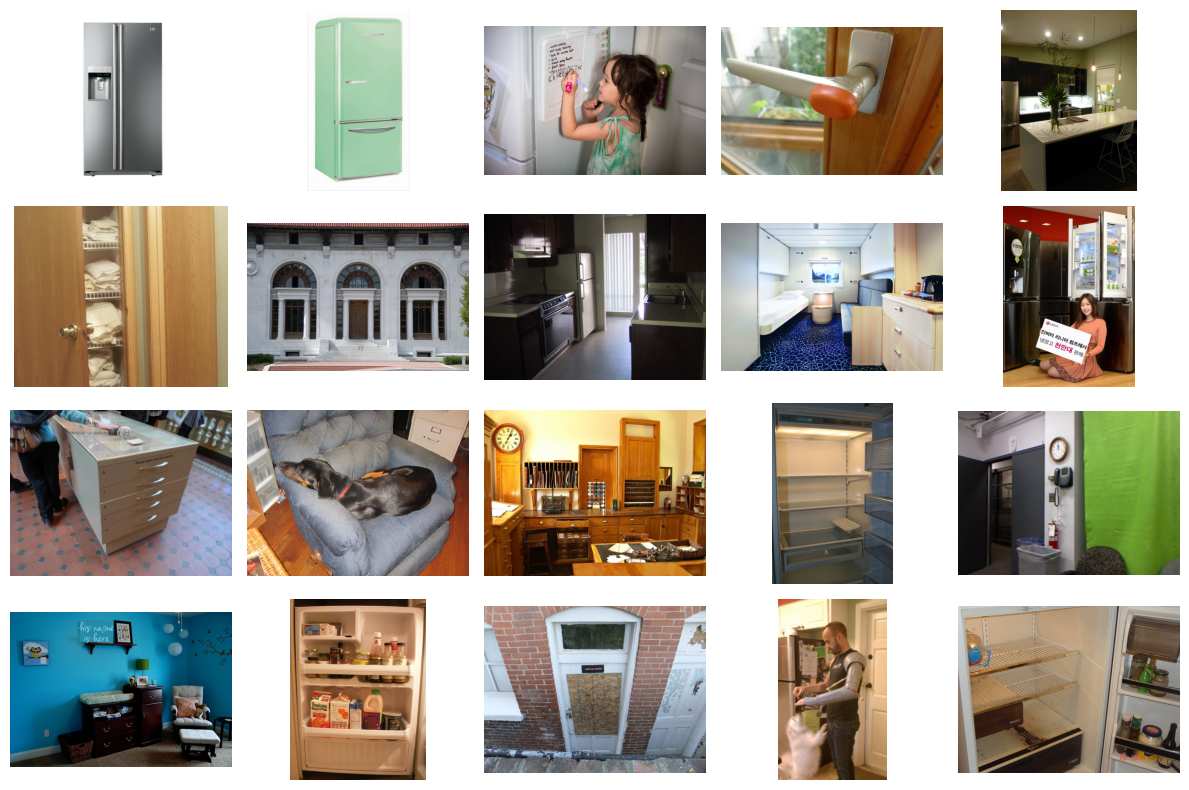

In [9]:
folder_path = CFG.custom_dataset_dir + "train/images/"
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed)

In [10]:
def get_image_properties(image_path):
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError("Could not read image file")

    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
print(img_properties)

{'width': 1024, 'height': 706, 'channels': 3, 'dtype': dtype('uint8')}


In [12]:
class_idx = {str(i): CFG.classes[i] for i in range(CFG.num_classes_to_train)}

class_stat = {}
data_len = {}
class_info = []

for mode in ["train", "valid", "test"]:
    class_count = {CFG.classes[i]: 0 for i in range(CFG.num_classes_to_train)}

    path = os.path.join(CFG.custom_dataset_dir, mode, "labels")

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({"Mode": mode, **class_count, "Data_Volume": data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context("display.max_columns", None):
    display(dataset_stats_df)

Mode  door  cabinetDoor  refrigeratorDoor  window  chair  table  cabinet  \
0  train   309          448               332     187    105    165      138   
1  valid    63           99                85      39     24     30       28   
2   test    25           42                 1      49     38     41       44   

   couch  openedDoor  pole  Data_Volume  
0     22          68    14          892  
1      1          13     4          199  
2     31          18     3          104

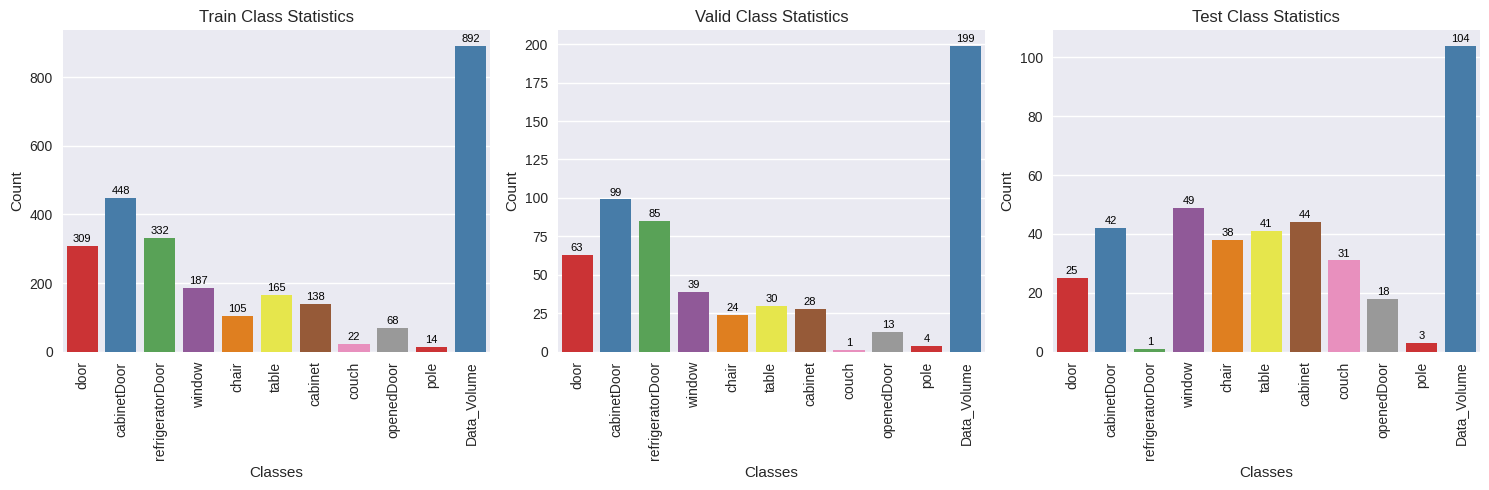

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, mode in enumerate(["train", "valid", "test"]):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df["Mode"] == mode].drop(columns="Mode"),
        orient="v",
        ax=axes[i],
        palette="Set1",
    )

    axes[i].set_title(f"{mode.capitalize()} Class Statistics")
    axes[i].set_xlabel("Classes")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=90)

    for p in axes[i].patches:
        axes[i].annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            fontsize=8,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

plt.tight_layout()
plt.show()

## Base Model Inference

In [14]:
model = YOLO(CFG.base_model_weights)

results = model.predict(
    source=example_image_path,
    classes=[0],
    conf=0.30,
    device=CFG.device,
    imgsz=CFG.imgsz,
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True,
    augment=True,  # enable augmentation
    max_det=100,  # set maximum detections per image
    
)


image 1/1 /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/images/0f6337a1ea2b6cc2.jpg: 544x768 (no detections), 105.2ms
Speed: 1.4ms preprocess, 105.2ms inference, 22.6ms postprocess per image at shape (1, 3, 544, 768)
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict
1 label saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict/labels


### Check predictions with base model

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (706, 1024, 3) 



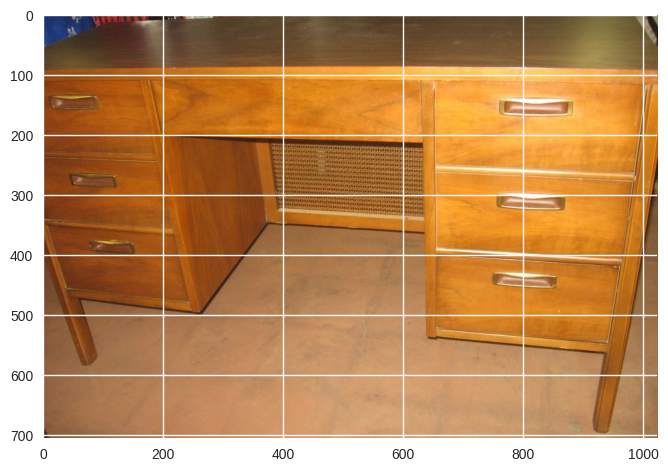

In [15]:

example_image_inference_output = example_image_path.split("/")[-1]
display_image(
    f"/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict/{example_image_inference_output}"
)

### Train
[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [16]:
print("Model: ", CFG.base_model)
print("Epochs: ", CFG.epochs)
print("Batch: ", CFG.batch_size)
print("Optimizer: ", CFG.optimizer)
print("Learning rate: ", CFG.lr)
print("GPU: ", CFG.device)

Model:  yolov9e
Epochs:  150
Batch:  8
Optimizer:  auto
Learning rate:  0.0003
GPU:  cuda


In [17]:
model = YOLO(CFG.base_model_weights)
torch.cuda.empty_cache()

In [18]:
print("Image size: ",(img_properties["height"], img_properties["width"]))
print(f"Image size (cfg): {CFG.imgsz}")

Image size:  (706, 1024)
Image size (cfg): 768


In [19]:
torch.cuda.empty_cache()

In [20]:
%%time

model.train(
    data=os.path.join(CFG.output_dir, "data.yaml"),
    task="detect",
    imgsz=CFG.imgsz,
    epochs=CFG.epochs,
    warmup_epochs=CFG.warmup_epochs,
    batch=CFG.batch_size,
    optimizer=CFG.optimizer,
    lr0=CFG.lr,
    lrf=CFG.lr_factor,
    cos_lr=True,
    weight_decay=CFG.weight_decay,
    dropout=CFG.dropout,
    patience=CFG.patience,
    profile=CFG.profile,
    label_smoothing=CFG.label_smoothing,
    name=f"{CFG.base_model}_{CFG.exp_name}",
    seed=CFG.seed,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    device=CFG.device,
    verbose=False,
    augment=CFG.augment['augment'],
    auto_augment="randaugment",
    mosaic=CFG.augment['mosaic'],
    close_mosaic=CFG.augment['close_mosaic'],
    copy_paste=CFG.augment['copy_paste'],
    copy_paste_mode=CFG.augment['copy_paste_mode'],
    # mixup=CFG.augment['mixup'],
    # hsv_h=CFG.augment['hsv_h'],
    # hsv_s=CFG.augment['hsv_s'],
    # hsv_v=CFG.augment['hsv_v'],
    # degrees=CFG.augment['degrees'],
    # translate=CFG.augment['translate'],
    # scale=CFG.augment['scale'],
)


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24083MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.15, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=True, multi_scale=False, name=yo

train: Scanning /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/labels... 992 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:00<00:00, 1942.02it/s]

train: New cache created: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4233.9±3678.0 MB/s, size: 314.6 KB)


val: Scanning /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid/labels... 226 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 3220.78it/s]

val: New cache created: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid/labels.cache


Plotting labels to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      16.6G      1.566      2.496      1.605         18        768: 100%|██████████| 127/127 [00:34<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.24it/s]

                   all        230       1289      0.298      0.225      0.161     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      15.4G      1.557      2.066      1.588         39        768: 100%|██████████| 127/127 [00:33<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.35it/s]

                   all        230       1289      0.492      0.214      0.145     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      15.4G      1.593      2.138      1.631         24        768: 100%|██████████| 127/127 [00:32<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.52it/s]

                   all        230       1289      0.229       0.24      0.131       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      15.4G      1.602      2.167      1.673         30        768: 100%|██████████| 127/127 [00:31<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]

                   all        230       1289      0.387      0.126     0.0715     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      15.4G      1.632      2.127      1.671         10        768: 100%|██████████| 127/127 [00:29<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.52it/s]

                   all        230       1289       0.57      0.218      0.149     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      15.4G        1.6      2.093      1.667         51        768: 100%|██████████| 127/127 [00:29<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]

                   all        230       1289       0.65        0.2      0.152      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      15.4G      1.567      1.984      1.631         11        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.51it/s]

                   all        230       1289      0.531      0.205      0.176     0.0888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      15.4G      1.534       1.93      1.617         51        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.72it/s]

                   all        230       1289      0.486      0.251      0.192     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      13.7G      1.535        1.9       1.62         39        768: 100%|██████████| 127/127 [00:31<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.75it/s]

                   all        230       1289      0.648      0.212        0.2      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      15.4G      1.523      1.911      1.615         24        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.64it/s]

                   all        230       1289        0.5      0.273      0.225      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      15.4G      1.476      1.822      1.584         25        768: 100%|██████████| 127/127 [00:32<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.39it/s]

                   all        230       1289      0.557      0.256      0.206      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      15.4G      1.471      1.777      1.564         47        768: 100%|██████████| 127/127 [00:32<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.67it/s]

                   all        230       1289      0.607      0.215       0.22      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      15.4G      1.476      1.715       1.57         51        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.67it/s]

                   all        230       1289      0.665      0.224       0.26      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      15.4G      1.438      1.672      1.533         44        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.618      0.244      0.243      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      15.4G      1.442      1.609       1.55         36        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

                   all        230       1289      0.556      0.302      0.274      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      13.7G      1.417      1.622      1.531         49        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289      0.439      0.317      0.264      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      15.4G      1.421      1.598      1.515         18        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.61it/s]

                   all        230       1289      0.538      0.269      0.261      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      15.3G      1.409      1.569      1.525         55        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.507       0.27      0.261      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      15.4G      1.416      1.577      1.539         31        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.42it/s]

                   all        230       1289      0.675      0.251      0.256      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      15.4G      1.401      1.599      1.532         46        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.64it/s]

                   all        230       1289      0.546      0.243      0.272      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      15.4G      1.372      1.503      1.482         65        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.371      0.322      0.289      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      15.4G      1.366      1.476      1.493         32        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.67it/s]

                   all        230       1289      0.598      0.302      0.287      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      15.4G       1.38      1.453      1.494         23        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.82it/s]

                   all        230       1289      0.478      0.296      0.274       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      15.4G      1.334      1.396      1.464         28        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.64it/s]

                   all        230       1289      0.475       0.33      0.278      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      15.4G      1.342       1.42      1.471         31        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.74it/s]

                   all        230       1289      0.607      0.312       0.29      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      15.3G      1.331      1.406      1.468         18        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.82it/s]

                   all        230       1289      0.494      0.301      0.298      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      15.4G      1.337      1.394      1.476         37        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.85it/s]

                   all        230       1289      0.639      0.308      0.322      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      15.4G       1.32      1.322      1.463         37        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.81it/s]

                   all        230       1289      0.427      0.298      0.283      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      15.4G      1.315      1.305       1.45         29        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.72it/s]

                   all        230       1289      0.459      0.374      0.381      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      15.4G      1.291      1.253      1.435         53        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.367      0.352      0.314      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      15.4G       1.29       1.32      1.446         48        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.521      0.297      0.311      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      15.4G      1.282       1.24      1.424         48        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.73it/s]

                   all        230       1289       0.38      0.353      0.306      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      15.4G       1.28      1.244      1.427         26        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.675      0.288      0.312       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      13.7G      1.278      1.226      1.446         24        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.578      0.309      0.332        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      15.4G      1.267      1.227      1.402         34        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.65it/s]

                   all        230       1289       0.49      0.338      0.332      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      15.4G      1.264       1.18      1.421         52        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

                   all        230       1289      0.545      0.323      0.327        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      15.4G      1.239      1.135       1.39         45        768: 100%|██████████| 127/127 [00:32<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.74it/s]

                   all        230       1289      0.433       0.37      0.353      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      15.4G       1.24      1.133      1.401         42        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.342      0.376      0.347      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      15.4G      1.231      1.146      1.394         55        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.511      0.326      0.359       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      15.4G      1.229      1.109       1.39         26        768: 100%|██████████| 127/127 [00:31<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        230       1289      0.435       0.36      0.351       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      15.4G      1.218      1.126      1.387         28        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.319      0.362      0.332      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      15.3G      1.219      1.127      1.387         42        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.485      0.314      0.354       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      15.4G      1.208      1.095      1.384         49        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.85it/s]

                   all        230       1289      0.384      0.373      0.387      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      15.4G      1.205      1.068      1.364         56        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.89it/s]

                   all        230       1289      0.395      0.376      0.388      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      15.4G      1.184      1.063      1.367         23        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.639      0.326      0.362      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      15.4G      1.199      1.028      1.356         30        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.632       0.29       0.34       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      15.4G      1.183      1.028      1.366         23        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.325      0.369      0.342      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      15.4G      1.157      1.018      1.345         75        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.587      0.299      0.356      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      13.7G       1.16     0.9917      1.334         33        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.81it/s]

                   all        230       1289       0.38       0.35      0.345      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      15.3G       1.17          1      1.356         37        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.93it/s]

                   all        230       1289      0.454       0.39      0.373      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      15.4G      1.155     0.9722      1.322         30        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289       0.47      0.393      0.363      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      15.4G      1.133     0.9737      1.322         28        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.52it/s]

                   all        230       1289      0.496      0.347      0.341      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      15.4G      1.124     0.9514      1.312         14        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.356      0.401      0.356      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      15.4G      1.118     0.9373      1.322         35        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.464      0.367      0.376      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      15.4G      1.123     0.9499      1.315         43        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.63it/s]

                   all        230       1289      0.397      0.423      0.392      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      15.4G      1.103     0.8961      1.314         46        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.434      0.399      0.376      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      15.4G      1.098     0.9129       1.31         64        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

                   all        230       1289      0.352      0.381      0.357      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      13.7G      1.101     0.8763      1.299         55        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.441      0.365      0.358      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      15.4G      1.079     0.8808      1.282         56        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.397      0.359      0.369      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      15.4G      1.062     0.8579      1.284         25        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.69it/s]

                   all        230       1289      0.502      0.347      0.382      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      15.4G      1.072     0.8363      1.273         34        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.494      0.357      0.359      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      15.4G      1.056     0.8329       1.26         48        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.369      0.357      0.353      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      13.7G       1.04     0.8199       1.26         32        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.468      0.368      0.382       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      15.4G      1.045     0.8241      1.271         32        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289       0.52      0.446      0.401      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      15.4G      1.031     0.7911      1.238         17        768: 100%|██████████| 127/127 [00:32<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.56it/s]

                   all        230       1289      0.346      0.512      0.389      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      13.7G      1.015     0.7998      1.254          7        768: 100%|██████████| 127/127 [00:32<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.99it/s]

                   all        230       1289      0.438      0.366      0.379       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      15.4G     0.9982     0.7924      1.238         52        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289       0.41      0.388      0.372      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      15.4G      1.009     0.7762      1.231         26        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289       0.48      0.461      0.407      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      15.4G     0.9845     0.7528      1.219         43        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.78it/s]

                   all        230       1289      0.365      0.405      0.377       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      15.4G     0.9881     0.7463       1.22         29        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.413      0.393      0.392      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      15.4G     0.9807     0.7296      1.224         62        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289       0.45      0.331      0.358       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      15.4G     0.9899     0.7724       1.23         80        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.78it/s]

                   all        230       1289      0.384      0.412       0.37      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      15.4G     0.9568     0.7051       1.21         73        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.434      0.378      0.388      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      15.3G     0.9455     0.7163      1.205         16        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.55it/s]

                   all        230       1289      0.386      0.367      0.384      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      15.4G     0.9552     0.7054      1.198         28        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.403      0.434      0.412      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      15.4G       0.95     0.7161      1.197         20        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.89it/s]

                   all        230       1289      0.383      0.423      0.393      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      15.4G     0.9351     0.6786      1.184         89        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.433       0.38      0.379      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      15.4G     0.9283     0.6786      1.185         39        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        230       1289      0.396      0.505      0.384      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      15.4G      0.924     0.6765      1.176         26        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

                   all        230       1289      0.348      0.423      0.365      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      15.4G     0.9132     0.6462       1.17         52        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.436      0.372      0.383      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      15.4G     0.8986     0.6301      1.161         30        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.54it/s]

                   all        230       1289      0.499      0.336      0.388      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      13.7G     0.8938     0.6372      1.161         19        768: 100%|██████████| 127/127 [00:32<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.51it/s]

                   all        230       1289      0.486      0.424      0.419      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      15.4G     0.8844     0.6476      1.149         24        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.409       0.38       0.36      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      15.4G     0.8734     0.6275      1.142         29        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.448      0.393      0.375       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      15.4G     0.8669     0.6044      1.127         56        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.459      0.476      0.405      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      15.4G     0.8615     0.6133      1.142         23        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.78it/s]

                   all        230       1289      0.455      0.368      0.395      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      13.7G     0.8602     0.6021      1.128         24        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.483      0.387        0.4      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      15.4G     0.8541     0.6082      1.131         49        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

                   all        230       1289      0.439       0.38      0.377      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      15.4G     0.8478     0.6058      1.122         27        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.441      0.366      0.391      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      13.7G     0.8316     0.5893      1.114         14        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        230       1289      0.537      0.372      0.392      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      15.4G     0.8294      0.565      1.117         58        768: 100%|██████████| 127/127 [00:31<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289      0.474      0.366      0.397      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      15.4G     0.8243     0.5641      1.111         22        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289      0.497      0.348      0.383      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      15.4G     0.8066     0.5528      1.088         61        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.373       0.42      0.366      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      15.4G     0.8002     0.5553      1.097         47        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.75it/s]

                   all        230       1289      0.389      0.404      0.377      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      15.4G     0.7906     0.5606      1.107         49        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289      0.435      0.394       0.38      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      15.4G     0.7822     0.5484      1.096         40        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.464      0.397      0.421      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      15.4G     0.7845     0.5503      1.094         51        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.57it/s]

                   all        230       1289      0.461      0.392      0.396      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      15.3G     0.7834     0.5286      1.086         27        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.93it/s]

                   all        230       1289      0.506      0.369      0.389      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      15.4G     0.7592      0.509      1.068         46        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.93it/s]

                   all        230       1289      0.424      0.379      0.386      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      15.4G     0.7617     0.5182      1.077         10        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.415      0.382      0.373      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      15.4G     0.7502     0.5142      1.069         33        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.87it/s]

                   all        230       1289      0.413      0.507      0.424      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      15.4G      0.755      0.509      1.066         46        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.422      0.364      0.375      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      13.7G     0.7551     0.5222       1.07         34        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.495      0.371      0.391      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      15.4G     0.7151     0.4937      1.047         64        768: 100%|██████████| 127/127 [00:31<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        230       1289      0.465      0.476      0.413      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      15.4G      0.732     0.4977      1.047         17        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

                   all        230       1289      0.555      0.446      0.424      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      15.3G     0.7262     0.4992      1.054         36        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.387      0.488      0.394       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      15.4G     0.7255      0.498      1.055         33        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.404      0.526      0.375      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      15.4G     0.7117     0.4726      1.042         74        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.59it/s]

                   all        230       1289      0.501      0.457      0.423      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      15.4G     0.7048      0.474      1.046         35        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.53it/s]

                   all        230       1289      0.481      0.521      0.443      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      15.4G     0.6968      0.463      1.033         34        768: 100%|██████████| 127/127 [00:32<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.92it/s]

                   all        230       1289       0.38      0.498      0.403      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      15.4G     0.6896     0.4552      1.025         51        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

                   all        230       1289       0.54      0.368      0.395      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      15.4G     0.6863     0.4595      1.023         70        768: 100%|██████████| 127/127 [00:32<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.45it/s]

                   all        230       1289      0.423       0.51      0.415       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      15.4G     0.6948     0.4607      1.032         57        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289       0.39      0.499      0.408      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      13.7G     0.6721     0.4458      1.021         45        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.55it/s]

                   all        230       1289        0.7       0.36      0.403      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      15.4G     0.6603      0.445      1.015         53        768: 100%|██████████| 127/127 [00:32<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.57it/s]

                   all        230       1289      0.584      0.359      0.404      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      15.4G      0.662      0.432      1.012         35        768: 100%|██████████| 127/127 [00:33<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.47it/s]

                   all        230       1289      0.512      0.462      0.429      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      15.4G     0.6591     0.4398      1.018         24        768: 100%|██████████| 127/127 [00:32<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.399      0.486      0.406      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      15.4G     0.6555     0.4417      1.018         45        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.63it/s]

                   all        230       1289      0.441      0.482      0.412       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      15.4G      0.663     0.4482      1.024         72        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

                   all        230       1289      0.426       0.45      0.395      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      15.4G     0.6486      0.439      1.018         24        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.462      0.479      0.407      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      15.4G     0.6378     0.4193      1.008         25        768: 100%|██████████| 127/127 [00:31<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.455      0.486      0.412      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      15.3G     0.6428     0.4255       1.01         28        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.71it/s]

                   all        230       1289      0.422       0.38      0.409      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      15.4G     0.6271     0.4216      1.006         43        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

                   all        230       1289      0.461      0.489      0.437      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      15.4G     0.6369     0.4155      1.002         18        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.74it/s]

                   all        230       1289      0.416       0.53      0.417       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      15.4G     0.6183     0.4115      1.007         34        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289      0.537      0.396      0.403      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      15.4G     0.6119     0.4097     0.9908         44        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.95it/s]

                   all        230       1289      0.414      0.509      0.413       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      15.4G     0.6241     0.4166     0.9989         23        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.90it/s]

                   all        230       1289      0.401      0.502      0.413      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      13.7G     0.6296     0.4348      1.001         31        768: 100%|██████████| 127/127 [00:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.96it/s]

                   all        230       1289      0.465      0.476      0.424      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      13.7G     0.6066     0.4099     0.9963         32        768: 100%|██████████| 127/127 [00:31<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.97it/s]

                   all        230       1289      0.455       0.47       0.41      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      13.7G     0.6033     0.4021     0.9879         62        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.77it/s]

                   all        230       1289      0.449       0.47      0.413      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      15.4G     0.6059     0.4025     0.9907         94        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

                   all        230       1289      0.547      0.494      0.411      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      15.4G     0.6078     0.4054     0.9834         13        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.82it/s]

                   all        230       1289      0.428      0.495      0.408      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      15.4G     0.6016     0.4106     0.9992         14        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.78it/s]

                   all        230       1289      0.424      0.504      0.416      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      15.4G     0.5972     0.4024     0.9912         30        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.449      0.481      0.421      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      15.4G     0.5903     0.3904     0.9791         15        768: 100%|██████████| 127/127 [00:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.445      0.497      0.414      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      15.4G     0.5967     0.3988     0.9893         65        768: 100%|██████████| 127/127 [00:32<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.84it/s]

                   all        230       1289      0.443      0.507      0.409       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      15.4G     0.5946      0.403     0.9805         50        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.566      0.491      0.411      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      13.7G     0.5958     0.3981     0.9828         39        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.81it/s]

                   all        230       1289      0.452      0.488      0.418      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      15.4G     0.5739      0.394     0.9808         17        768: 100%|██████████| 127/127 [00:32<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]

                   all        230       1289      0.583      0.485      0.423      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      15.4G     0.5869      0.384     0.9813         24        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.72it/s]

                   all        230       1289      0.455      0.484      0.416      0.266


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      15.4G     0.5633     0.3431     0.9577         41        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.73it/s]

                   all        230       1289      0.395      0.501      0.384      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      15.4G     0.5593     0.3276     0.9635         13        768: 100%|██████████| 127/127 [00:31<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.12it/s]

                   all        230       1289      0.406      0.488      0.389      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      15.4G     0.5518     0.3249      0.957         19        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.70it/s]

                   all        230       1289      0.443      0.518      0.398      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      15.4G     0.5356     0.3085     0.9458          9        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.77it/s]

                   all        230       1289      0.386      0.516      0.396      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      13.7G     0.5349     0.3126     0.9483         13        768: 100%|██████████| 127/127 [00:32<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.75it/s]

                   all        230       1289      0.394      0.505      0.394      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      13.7G     0.5297     0.3107     0.9426         28        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

                   all        230       1289      0.529      0.492      0.398      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      15.4G     0.5401     0.3156     0.9398         11        768: 100%|██████████| 127/127 [00:32<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]

                   all        230       1289      0.407      0.467      0.394      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      15.4G     0.5174     0.3042     0.9301         15        768: 100%|██████████| 127/127 [00:31<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

                   all        230       1289      0.518      0.453      0.393      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      15.4G     0.5291     0.3024     0.9372         18        768: 100%|██████████| 127/127 [00:32<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.78it/s]

                   all        230       1289      0.539      0.501      0.401       0.25
EarlyStopping: Training stopped early as no improvement observed in last 40 epochs. Best results observed at epoch 109, best model saved as best.pt.
To update EarlyStopping(patience=40) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



149 epochs completed in 1.442 hours.
Optimizer stripped from /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/last.pt, 117.3MB
Optimizer stripped from /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt, 117.3MB

Validating /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24083MiB)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


                   all        230       1289      0.503      0.462      0.448      0.288
Speed: 0.1ms preprocess, 16.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs
CPU times: user 58min 46s, sys: 30min 4s, total: 1h 28min 51s
Wall time: 1h 26min 41s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x74005e774080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

### Export the model

In [21]:
model.export(
    format="onnx",  # openvino, onnx, engine, tflite
    imgsz=CFG.imgsz,
    half=False,
    int8=False,
    simplify=False,
    nms=False,
)

Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu126 CPU (Intel Core(TM) i9-14900KF)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from '/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt' with input shape (1, 3, 768, 768) BCHW and output shape(s) (1, 14, 12096) (111.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 1.8s, saved as '/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.onnx' (219.4 MB)

Export complete (3.0s)
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights
Predict:         yolo predict task=detect model=/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.onnx imgsz=768  
Validate:

'/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/weights/best.onnx'

### Train results

In [22]:
def extract_class_map(metrics, label=""):
    """
    Extracts class-wise mAP from the metrics object.
    """
    names = metrics.names
    maps = metrics.maps
    df = pd.DataFrame(
        {
            "class_id": list(names.keys()),
            "class_name": list(names.values()),
            f"mAP@0.5 ({label})": maps,
        }
    )
    return df

metrics = model.val(
    model=os.path.join(CFG.output_dir, "runs", "detect", f"{CFG.base_model}_{CFG.exp_name}", "weights", "best.pt")
)

df_map = extract_class_map(metrics)

df_map.sort_values("class_id", inplace=True)
display(df_map)

Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24083MiB)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5616.7±4023.9 MB/s, size: 223.8 KB)


val: Scanning /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid/labels.cache... 226 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]


                   all        230       1289      0.502      0.457      0.455      0.291
Speed: 0.3ms preprocess, 24.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs


class_id        class_name  mAP@0.5 ()
0         0              door    0.318821
1         1       cabinetDoor    0.480766
2         2  refrigeratorDoor    0.535819
3         3            window    0.231297
4         4             chair    0.327707
5         5             table    0.053489
6         6           cabinet    0.297505
7         7             couch    0.447750
8         8        openedDoor    0.134362
9         9              pole    0.083275

### Plots

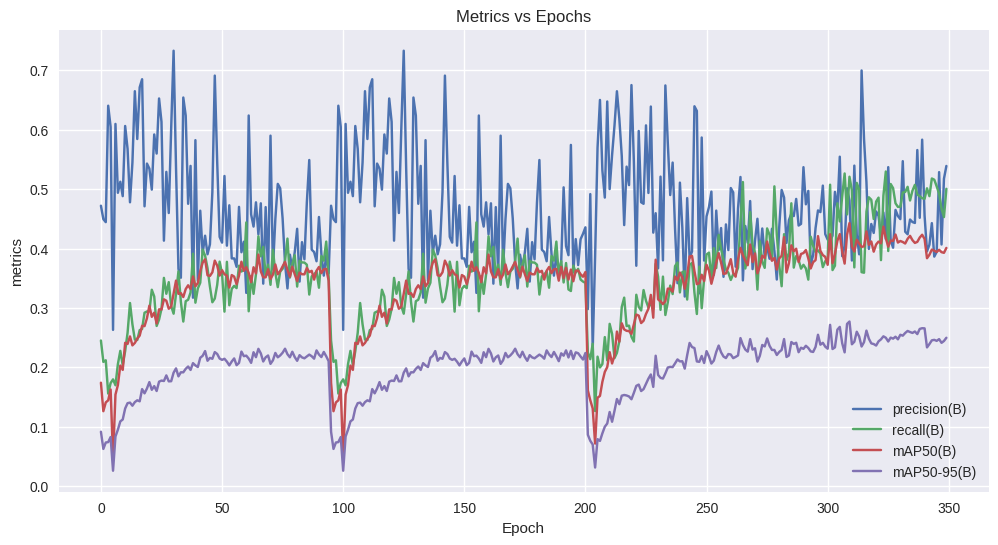

In [23]:
def load_results_csv(csv_path):
    """
    Loads the results CSV file from the YOLO training run.

    Args:
        csv_path (str): Path to the CSV file

    Returns:
        DataFrame or None: DataFrame with metrics or None if the file is not found
    """

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        return df
    else:
        print(f"file not found: {csv_path}")
        return None


path_csv = os.path.join(
    CFG.output_dir,
    "runs",
    "detect",
    f"{CFG.base_model}_{CFG.exp_name}",
    "results.csv",
)

df_results = load_results_csv(path_csv)

possible_metrics = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/mAP_0.5(B)",
    "metrics/mAP_0.5:0.95(B)",
]

if df_results is not None:
    actual_metrics = [
        m
        for m in possible_metrics
        if m in df_results.columns and m in df_results.columns
    ]

    plt.figure(figsize=(12, 6))
    for metric in actual_metrics:
        plt.plot(df_results[metric], label=f"{metric.split('/')[-1]}")
    plt.legend()
    plt.title("Metrics vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("metrics")
    plt.grid(True)
    plt.show()

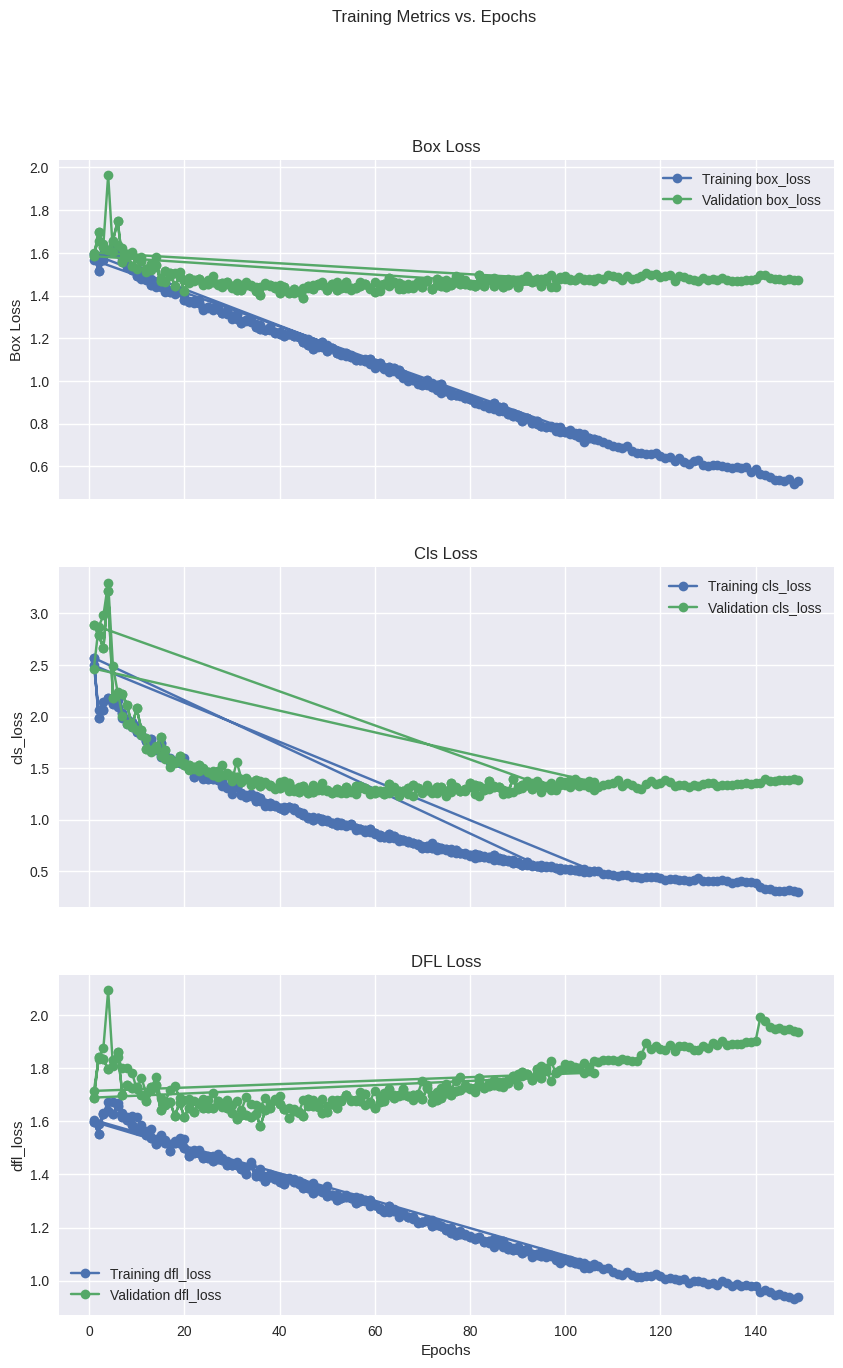

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title("Box Loss")
ax1.plot(
    df_results["epoch"],
    df_results["train/box_loss"],
    label="Training box_loss",
    marker="o",
    linestyle="-",
)
ax1.plot(
    df_results["epoch"],
    df_results["val/box_loss"],
    label="Validation box_loss",
    marker="o",
    linestyle="-",
)
ax1.set_ylabel("Box Loss")
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title("Cls Loss")
ax2.plot(
    df_results["epoch"],
    df_results["train/cls_loss"],
    label="Training cls_loss",
    marker="o",
    linestyle="-",
)
ax2.plot(
    df_results["epoch"],
    df_results["val/cls_loss"],
    label="Validation cls_loss",
    marker="o",
    linestyle="-",
)
ax2.set_ylabel("cls_loss")
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title("DFL Loss")
ax3.plot(
    df_results["epoch"],
    df_results["train/dfl_loss"],
    label="Training dfl_loss",
    marker="o",
    linestyle="-",
)
ax3.plot(
    df_results["epoch"],
    df_results["val/dfl_loss"],
    label="Validation dfl_loss",
    marker="o",
    linestyle="-",
)
ax3.set_xlabel("Epochs")
ax3.set_ylabel("dfl_loss")
ax3.legend()
ax3.grid(True)

plt.suptitle("Training Metrics vs. Epochs")
plt.show()

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/F1_curve.png


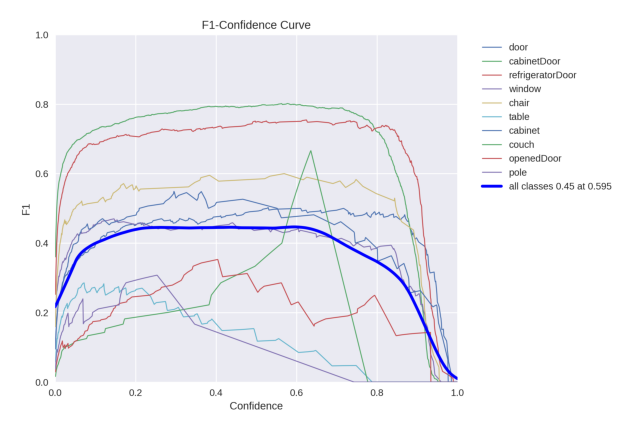



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/PR_curve.png


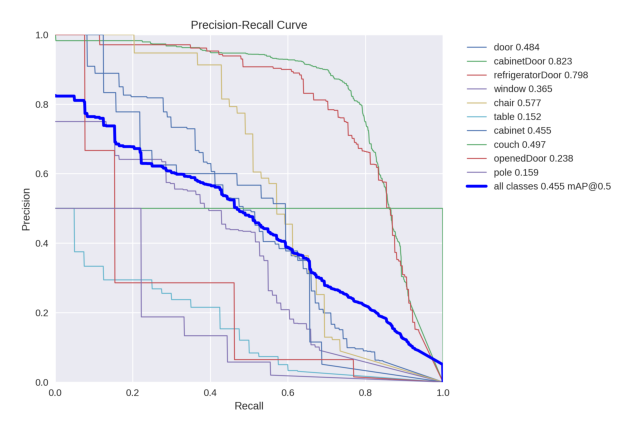



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/P_curve.png


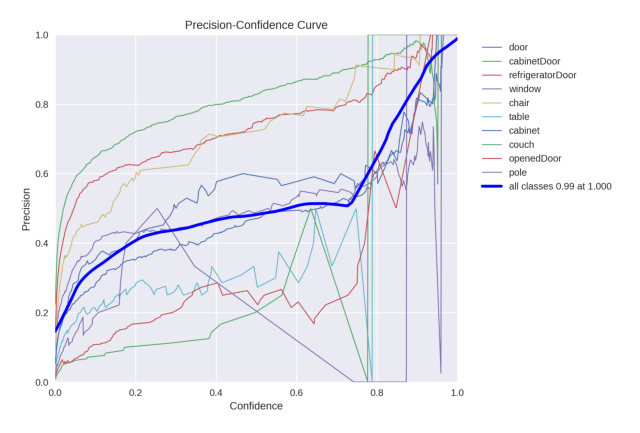



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/R_curve.png


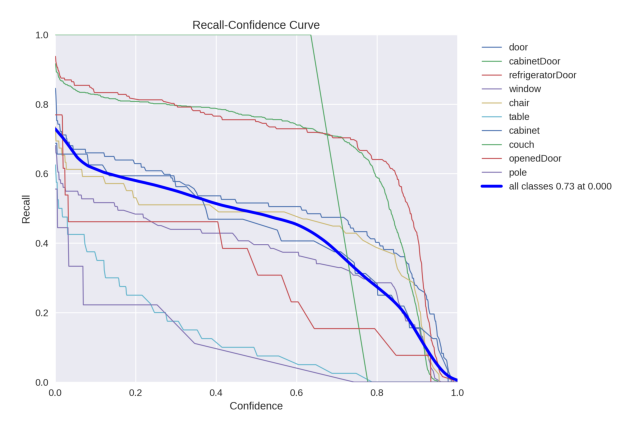



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix.png


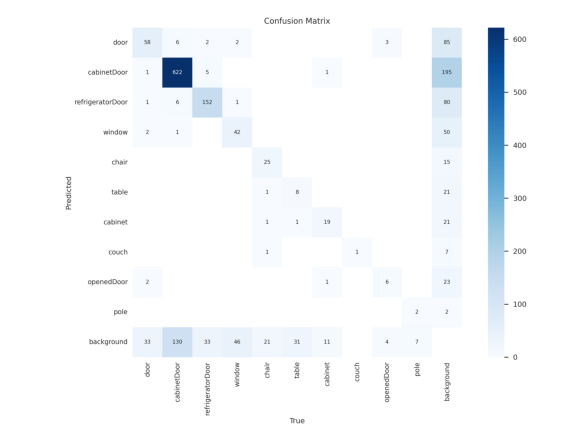



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix_normalized.png


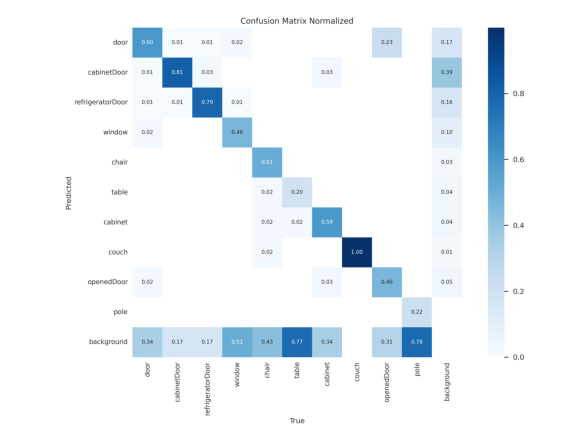



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/labels.jpg


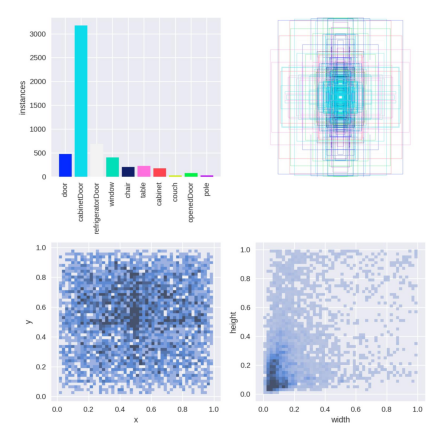



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/labels_correlogram.jpg


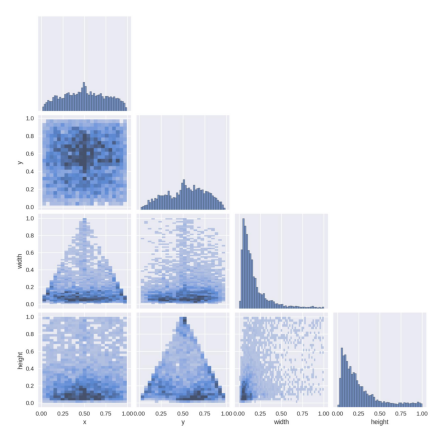



/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/results.png


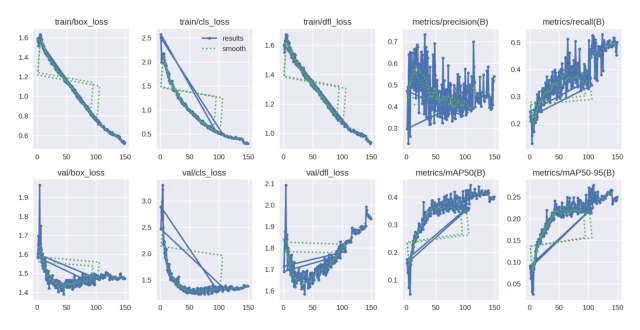

In [25]:
results_paths = [
    i
    for i in glob.glob(
        f"{CFG.output_dir}/runs/detect/{CFG.base_model}_{CFG.exp_name}/*.png"
    )
    + glob.glob(f"{CFG.output_dir}/runs/detect/{CFG.base_model}_{CFG.exp_name}/*.jpg")
    if "batch" not in i
]
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info=False, hide_axis=True)
    print("\n")

In [26]:
print('*'*50)
print('\nBest Training Box loss: ', df_results['train/box_loss'].min(), ', on epoch: ', df_results['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df_results['val/box_loss'].min(), ', on epoch: ', df_results['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df_results['train/cls_loss'].min(), ', on epoch: ', df_results['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df_results['val/cls_loss'].min(), ', on epoch: ', df_results['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df_results['train/dfl_loss'].min(), ', on epoch: ', df_results['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df_results['val/dfl_loss'].min(), ', on epoch: ', df_results['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.51736 , on epoch:  349 


Best Validation Box loss:  1.38951 , on epoch:  45 


Best Training Cls loss:  0.30236 , on epoch:  350 


Best Validation Cls loss:  1.22984 , on epoch:  276 


Best Training DFL loss:  0.93011 , on epoch:  349 


Best Validation DFL loss:  1.5832 , on epoch:  36 



### Check predictions or labels from a random validation batch

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch2_labels.jpg


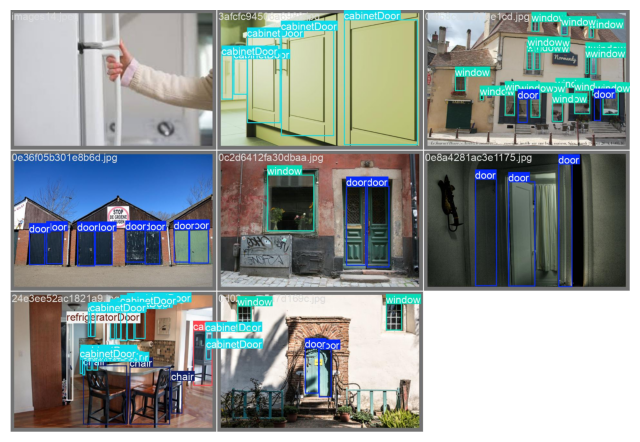

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch2_pred.jpg


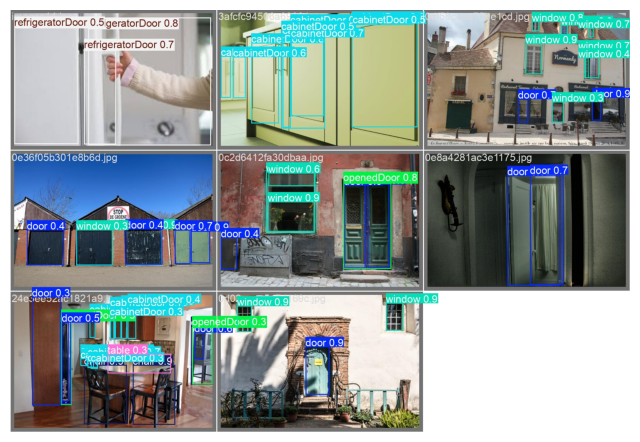

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch1_pred.jpg


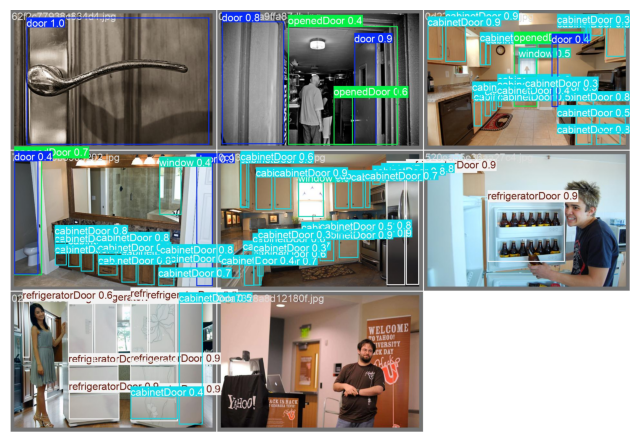

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch0_labels.jpg


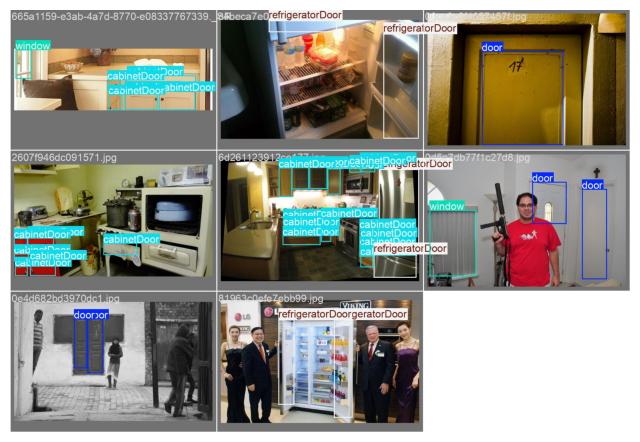

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch0_pred.jpg


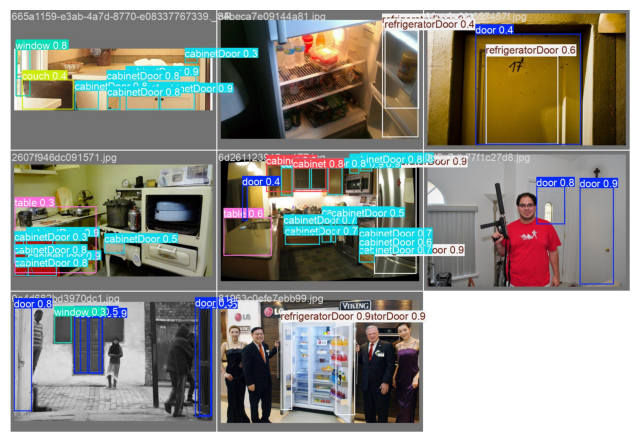

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_150_epochs/val_batch1_labels.jpg


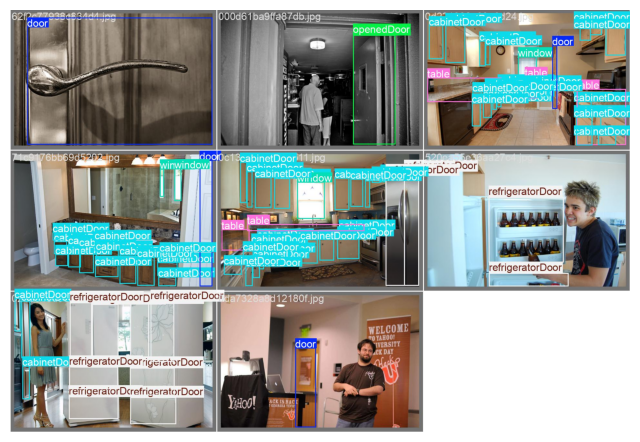

In [27]:
validation_results_paths = [
    i
    for i in glob.glob(f"{CFG.output_dir}/runs/detect/{CFG.base_model}_{CFG.exp_name}/*.jpg")
    if "val_batch" in i
]

if len(validation_results_paths) >= 1:
    for val_img_path in validation_results_paths:
        print(val_img_path)
        display_image(val_img_path, print_info=False, hide_axis=True)

## Conclusions

Для покращення результатів тренування було додатково оброблено дані, дані класів сильно не збалансовані. Також виявилось що в датасеті присутні дані без міток. Що було зроблено:
- Додано праметри для розширеної аугментації. 
- Увімкнені mosaic + randaugment додали 15%.
- Auto optimizer / lr — AdamW з lr≈7 e‑4 прискорив збіжність.
- AutoAnchor + imgsz 768 — приріст Precision у простих класах.

Можливі покращення:
- Застосувати WeightedRandomSampler або oversampling длдя класів з малою кількістю спостережень - couch, openedDoor, pole.
- Спробувати додати фонового шуму mixup = 0.5 (зараз 0) і замінити auto_augment="randaugment".
- Зменшити dropout до 0.05 це можливо збільшить точність.

Висновок: перш за все обов'язково потрібно ретельно підбирати датасети для навчання із збалансованими даними, також обов'язково варто звернути увагу/перевірити розмітку даних, чи всі дані відмічені.
